<a href="https://colab.research.google.com/github/shakebkhan/bdda1/blob/main/7_higgs_boson_xgb_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 30th Oct, 2022
Ref:
 1. https://github.com/harnalashok/classification/blob/main/optimization%20%26%20hyperparameter/7.higgs_pipeline_xgboostBayesOpt_simple.py
 2. http://krasserm.github.io/2018/03/21/bayesian-optimization/

Objectives:
    1. Reading from hard-disk random samples of big-data
    2. Using PCA
    3. Pipelining with StandardScaler, PCA and xgboost
    4. Grid tuning of PCA and xgboost--Avoid data leakage
    5. Randomized search of parameters
    6. Bayes optimization
    7. Feature importance
    8. Genetic algorithm for tuning of parameters
    9. Find feature importance of any Black box estimator
       using Permutation

See this file in github:
    7.higgs_pipeline_xgboostBayesOpt_simple.py
"""

## Install packages

In [1]:
# 0.0
# For skopt routines
! pip install scikit-optimize

# 0.1 For plotting skopt results
! pip install 'scikit-optimize[plots]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.3 MB/s eta 0:00:00


Ensemble learning helps improve machine learning results by combining several models. This approach allows the production of better predictive performance compared to a single model. There are two approaches:

> **Bagging**: It is a homogeneous weak learners’ model that learns from each other independently in parallel and combines them for determining the model average. RandomForest model is an example of bagging.<br>

>**Boosting**: It is also a homogeneous weak learners’ model but works differently from Bagging. In this model, learners learn sequentially and adaptively to improve model predictions of a learning algorithm. Gradient boosting is an example of Boosting.

## Gradient Boosting

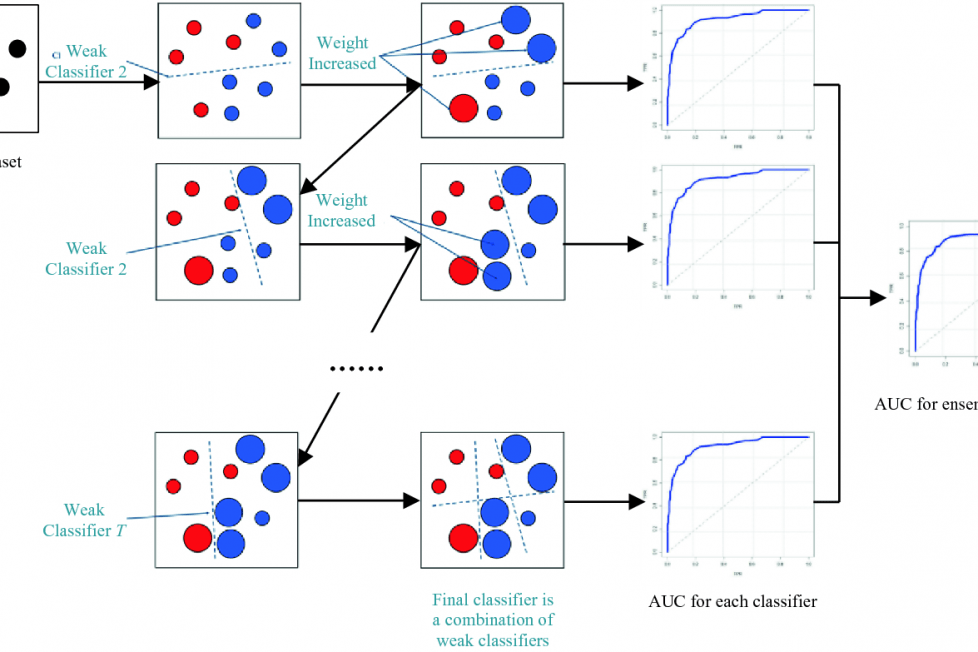

Gradient Boosting

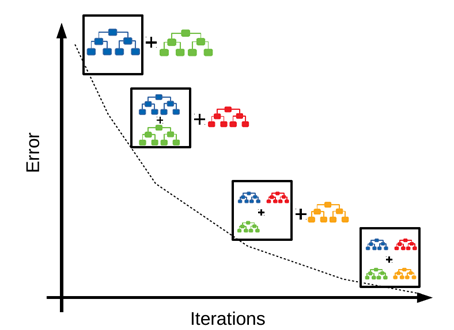

## About L1 and L2 regularization
Please see [this](https://towardsdatascience.com/regularization-in-machine-learning-connecting-the-dots-c6e030bfaddd) reference and [this](https://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models) one.

Regularization can be understood as a technique to improve the generalizability of a learned model.  A simpler model may underfit and will perform poorly with predictions. Just because two data points fit a line perfectly doesn’t mean that a third point will fall exactly on that line — in fact, it’s highly unlikely. One needs to move from simpler model to complex model to improve upon predictions. It is here that regularization helps by stopping us on the way and not allowing the model to be over-complex as to overfit the model.  

Simply put, regularization penalizes models that are more complex in favor of simpler models (ones with smaller regression coefficients) — but not at the expense of reducing predictive power.

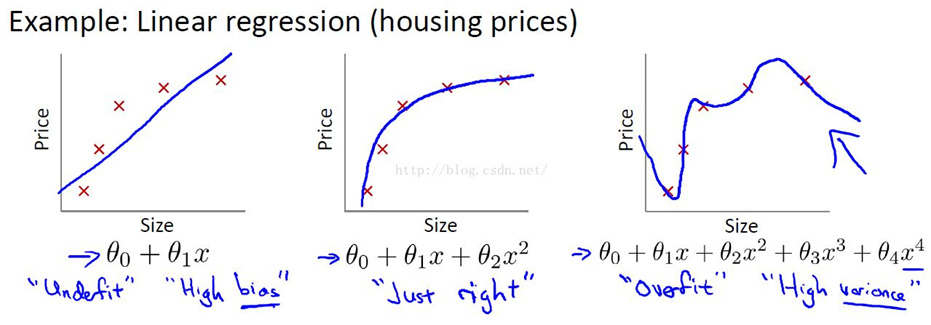

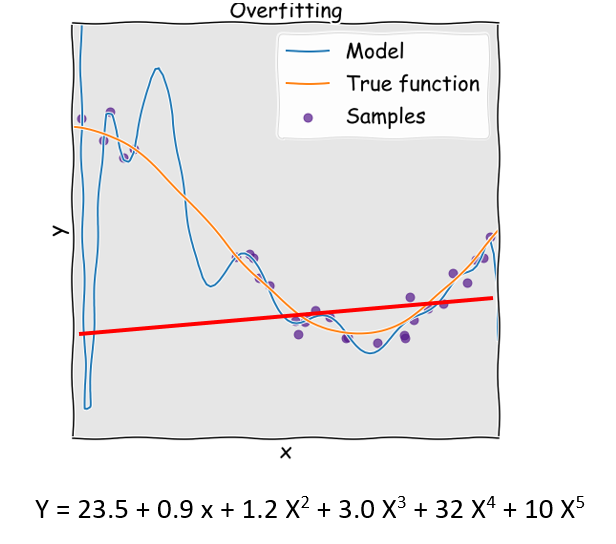

The above equation will result in a large change in Y even with a small change in X. Hence, there will be a large variance.

### Penalty terms

Regularization works by biasing data towards particular values (such as small values near zero). The bias is achieved by adding a tuning parameter to encourage those values:

> L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients. In other words, it limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. Lasso regression uses this method.

> L2 regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated). Ridge regression and SVMs use this method.

> Elastic nets combine L1 & L2 methods, but does add a second hyperparameter.


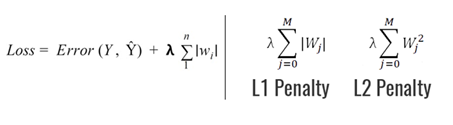

#### Elastic net

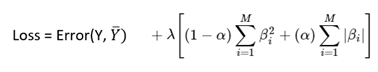

### Regularization how it works

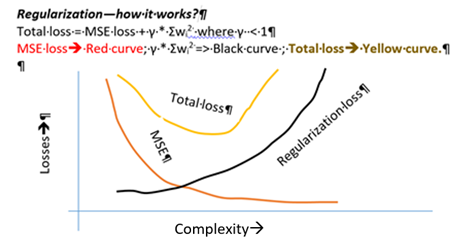

*gamma* hyperparameter:<br>
>The shape of '*Regularization loss*' (and hence of *Total loss*') curve will depend upon constant '*gamma*' (or *alpha*). Select that value of '*gamma*' for which we get minimum Total Loss at some point.

L1 penality can sometimes lead to a value of coefficients where one of them is zero (but this is not always true). L1 models are therefore sparse, easy to store (as some coefficients are zero) and can also indicate feature importance.

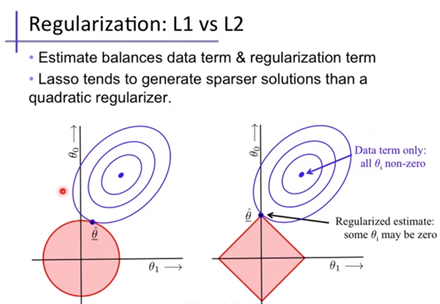

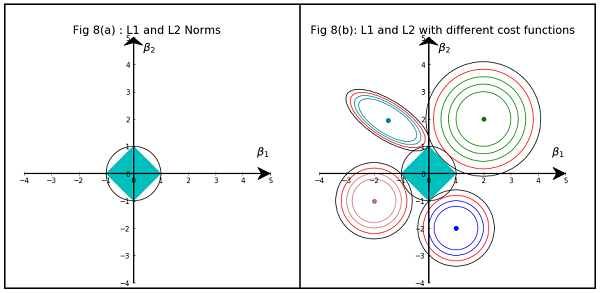

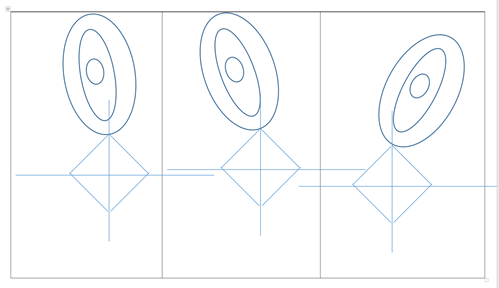

GBM model building steps (simplified version):
=============================================
> I decide to build GBM model with four functions:<br>
>> So the GBM model is: K +  f1(X) + f2(X) + f3(X) + f4(X)<br>

>Can I reduce error further by giving different importance to each one of the functions above. So, I search for weights that would do this. Here is my final model:<br>

>> The final GBM model is: K +  w1 * f1(X) + w2 * f2(X)+ w3 * f3(X)+ w4 * f4(X)<br>

>In practice, if I use a learning rate (α), model works better. So overall model is (α varies from 0 to 1):<br>

>>K +  α* w1*f1(X) + α* w2 * f2(X)+ α* w3*f3(X)+ α* w4*f4(X)<br>


## Call libraries

In [2]:
# 1.0 Clear ipython memory
#%reset -f

# 1.1 Data manipulation and plotting modules
import numpy as np
import pandas as pd


# 1.2 Data pre-processing
#     z = (x-mean)/stdev
from sklearn.preprocessing import StandardScaler as ss

# 1.3 Dimensionality reduction and noise removal
from sklearn.decomposition import PCA

# 1.4 Data splitting and model parameter search
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# 1.5 Model pipelining
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# 1.6 Hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 1.7.1
#     pip install scikit-optimize
#     pip install 'scikit-optimize[plots]'
#     Refer: https://github.com/scikit-optimize/scikit-optimize
#     conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# 1.8 Modeling modules
#     Call sklearn wrapper of xgboost
# """Scikit-Learn Wrapper interface for XGBoost."""
#  """Implementation of the Scikit-Learn API for XGBoost.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# Stackoverflow:
# https://stackoverflow.com/a/34696477
# https://stackoverflow.com/a/46947191
# Install as: conda install -c anaconda py-xgboost
from xgboost.sklearn import XGBClassifier

In [3]:
# 1.9 Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

# 1.10
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# 1.11 Permutation feature importance
from sklearn.inspection import permutation_importance

In [4]:
# 1.12 Misc
import time
import os
import gc
import random

# 1.13 Used in Randomized parameter search
from scipy.stats import uniform

In [5]:
# 1.14
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# 1.15 Set option to dislay many rows
pd.set_option('display.max_columns', 100)

## Mount gdrive

In [7]:
# 1.16 If you are using colab
#      Execute following code
#      to mount your gdrive

from google.colab import drive
# Path where to mount MyDrive
# We will mount it at /ashok
# This drive will be created
drive.mount('/gdrive')


Mounted at /gdrive


## Read Data
Simple processing and finally split data into train/test
(#2.0--#4.1)

#### Read a sample of data

We will read a sample of data from harddisk. Pandas has a facility not to read into RAM complete data but a random fraction of it.

In [8]:
################# BB. Read data randomly #################
# 2.0 Read random chunks of 10% of data

path = "/gdrive/MyDrive/bdda1/"

In [9]:
# 2.1 Set working directory
#     to where data is
os.chdir(path)
os.listdir()

['producttesting.zip', 'hb.csv.zip']

In [10]:
# 2.2 Our data file
tr_f = "hb.csv.zip"

# 2.3 Total number of rows: 250001
#     But we will read 40% of data randomly
total_lines = 250000
num_lines = 0.4 * total_lines    # 40% of data


# 2.4 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = num_lines/total_lines  # fraction of lines to read (40%)

In [11]:
# 2.4.1 How to pick up random rows from hard-disk
#       without first loading the complete file in RAM
#       Toss a coin:
#           At each row, toss a biased-coin: 60%->Head, 40%->tail
#           If tail comes, select the row else not.
#           Toss a coin: random.random()
#           Head occurs if value > 0.6 else it is tail
#
#       We do not toss the coin for header row. Keep the header

data = pd.read_csv(
         tr_f,
         header=0,   # First row is header-row
         # 'and' operator returns True if both values are True
         #  random.random() returns values between (0,1)
         #  No of rows skipped will be around 60% of total
         skiprows=lambda i: (i >0 ) and (random.random() > p)    # (i>0) implies skip first header row
         )



## Explore data and process data

In [12]:
# 3.0 Explore data
print("\n Shape")
data.shape                # 100039, 33)
print("\n\n Columns")
data.columns.values       # Label column is the last one
print("\n")

# 3.0.1
print("\n\nTarget distribution")
data.Label.value_counts()  # Classes are not unbalanced
                           # Binary data
                           #  b: 65558 , s: 34242
# 3.0.2
print("\n\nData types")
data.dtypes.value_counts()  # Label column is of object type
print("\n")
data.head(3)


 Shape


(99945, 33)



 Columns


array(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',
       'PRI_jet_all_pt', 'Weight', 'Label'], dtype=object)





Target distribution


b    65674
s    34271
Name: Label, dtype: int64



Data types


float64    30
int64       2
object      1
dtype: int64

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100001,160.937,68.768,103.235,48.146,-999.0,-999.0,-999.0,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.0,-999.0,-999.0,46.226,2.233584,b
1,100012,145.297,64.234,103.565,106.999,-999.0,-999.0,-999.0,2.183,24.660,192.245,0.576,0.689,-999.0,62.890,-0.766,-1.632,36.237,0.722,-0.035,43.910,-1.907,232.362,1,93.117,-0.970,1.943,-999.0,-999.0,-999.0,93.117,1.681611,b
2,100014,-999.000,109.412,14.398,17.323,-999.0,-999.0,-999.0,0.472,17.323,62.565,1.774,-0.272,-999.0,22.552,1.389,1.340,40.013,1.856,1.412,75.197,-1.583,198.616,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,0.000,2.151199,b


In [13]:
# 3.1 Examine data statistics
data.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000,99945.000000
mean,224646.463185,-48.712753,49.081068,81.313354,57.627922,-710.788355,-604.775314,-711.714969,2.377892,18.796926,157.933079,1.435513,-0.132794,-711.347163,38.694861,-0.013683,-0.013926,46.525149,-0.023037,0.044945,41.617916,-0.013568,209.281293,0.974896,-349.510420,-400.253188,-400.255597,-694.878232,-711.480659,-711.480581,72.713069,1.648717
std,72236.759044,406.390855,35.229596,41.018224,63.439948,453.379015,655.191309,451.924438,0.784880,21.447283,115.405417,0.847930,1.193358,452.499063,22.501157,1.214411,1.818756,21.939581,1.265325,1.814243,32.679757,1.814671,126.050048,0.975219,533.096964,489.541768,489.539869,478.712669,452.290326,452.290186,97.716210,1.876213
min,100001.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.212000,0.082000,-1.414000,-999.000000,20.000000,-2.498000,-3.142000,26.000000,-2.490000,-3.142000,0.162000,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162013.000000,78.147000,19.211000,59.349000,13.925000,-999.000000,-999.000000,-999.000000,1.814000,2.821000,77.309000,0.883000,-1.371000,-999.000000,24.578000,-0.930000,-1.586000,32.351000,-1.020000,-1.520000,21.298000,-1.583000,122.606000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.018636
50%,224493.000000,104.978000,46.422000,73.769000,38.169000,-999.000000,-999.000000,-999.000000,2.494000,12.187000,120.055000,1.278000,-0.381000,-999.000000,31.760000,-0.028000,-0.035000,40.444000,-0.050000,0.088000,34.637000,-0.023000,179.202000,1.000000,38.799000,-1.885000,-2.100000,-999.000000,-999.000000,-999.000000,40.262000,1.162885
75%,287230.000000,130.708000,73.366000,92.314000,78.712000,0.470000,81.913000,-4.754000,2.966000,27.470000,199.711000,1.772000,1.223000,0.000000,44.978000,0.898000,1.558000,53.197000,0.955000,1.619000,51.756000,1.558000,262.695000,2.000000,75.031000,0.433000,0.504000,33.457000,-2.511000,-2.318000,109.269000,2.411522
max,349999.000000,988.199000,571.868000,1349.351000,1053.807000,8.287000,4543.913000,16.219000,5.642000,466.525000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.499000,3.142000,951.363000,3.142000,2003.976000,3.000000,1120.573000,4.492000,3.141000,721.456000,4.497000,3.142000,1606.872000,7.822543


In [14]:
# 3.2 We do not need Id column and Weight column
data.drop(columns = ['EventId','Weight'],inplace = True  )

In [15]:
# 3.3 Divide data into predictors and target
#     First 30 columns are predictors

X = data.iloc[ :, 0:30]
X.head(2)

# 3.3.1 30th index or 31st column is target
print("\n\nTarget,y, values")
y = data.iloc[ : , 30]
y.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,160.937,68.768,103.235,48.146,-999.0,-999.0,-999.0,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.0,-999.0,-999.0,46.226
1,145.297,64.234,103.565,106.999,-999.0,-999.0,-999.0,2.183,24.660,192.245,0.576,0.689,-999.0,62.890,-0.766,-1.632,36.237,0.722,-0.035,43.910,-1.907,232.362,1,93.117,-0.970,1.943,-999.0,-999.0,-999.0,93.117




Target,y, values


0    b
1    b
2    b
3    s
4    s
Name: Label, dtype: object

In [16]:
# 3.3.2 Can we change datatype to float32 ?
#       Check.
X.min().min()           # -999.0
X.max().max()           # 4543.913

# 3.3.3  Save memory
X = X.astype('float32')


-999.0

4543.913

In [17]:
# 3.4 Transform label data to '1' and '0'
#    'map' works element-wise on a Series.
y = y.map({'b':1, 's' : 0})
y.dtype           # int64


# 3.5 Store column names somewhere
#     for use in feature importance

colnames = X.columns.tolist()


dtype('int64')

#### Split data into train/test

In [18]:

# 4. Split dataset into train and validation parts
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    shuffle = True,
                                                    stratify = y
                                                    )

# 4.1
X_train.shape        # (65025, 30)
X_test.shape         # (35014, 30)
y_train.shape        # (65025,)
y_test.shape         # (35014,)

(64964, 30)

(34981, 30)

(64964,)

(34981,)

## Create a pipeline
Create a pipeline for data processing and modeling. We will then use `Grid Search` and `Random Search` to find best set of parameters for this pipeline.

In [19]:
################# CC. Create pipeline #################
#### Pipe using XGBoost


# 5.0 Pipeline steps
# steps: List of (name, transform) tuples
#       (implementing fit/transform) that are
#       chained, in the order in which they
#       are chained, with the last object an
#       estimator.
#      Format: [(name, transformer), (name, transformer)..(name, estimator)]

steps_xg = [('sts', ss() ),
            ('pca', PCA()),
            ('xg',  XGBClassifier(silent = False,
                                  n_jobs=3)        # Specify other parameters here
            )
            ]

In [20]:
# 5.1  Instantiate Pipeline object

pipe_xg = Pipeline(steps_xg)

# 5.2 Another way to create pipeline:
#     Not used below

#pipe_xg1 = make_pipeline (
#                          ss(),
#                          PCA(),
#                          XGBClassifier(silent = False,
#                                        n_jobs=2)
#                          )

## Cross Validation
Understanding cross-validation

### Part picture

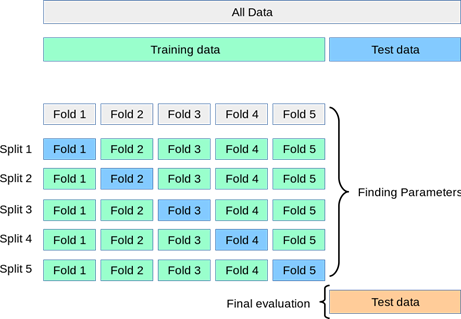

### Full picture

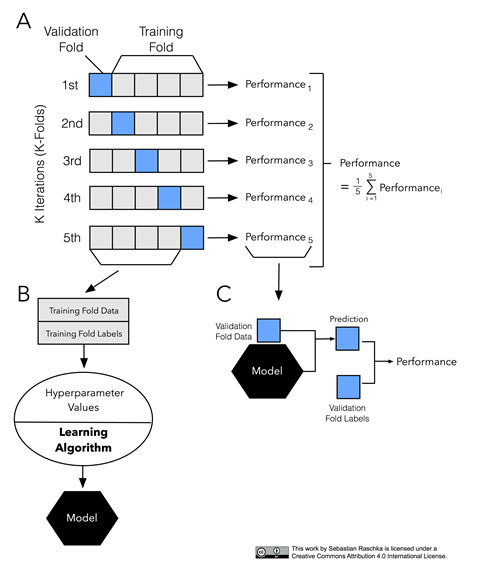

## Grid Search vs Random Search
See this [link](https://stats.stackexchange.com/a/209409) and this [link](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35).

### How they work?

Green curves show true objective function as a function of the given parameter. While Grid search misses the Objective function completely, Random Search does not. (We are assuming here that one parameter is important and the other not. So the Objective function depends completely on the values of one parameter.)

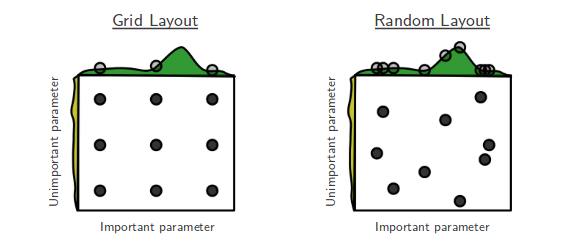

Random search can still miss the global optimum completely, as in the following illustration.

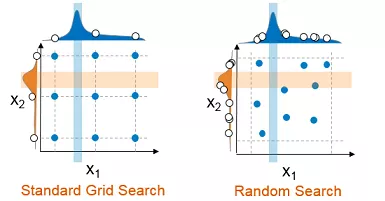

Intuitively, both for Grid Search as also for Random Search, it would be more efficient to choose the next hyperparameter combination according to past combinations performances. <u>A mutual drawback of both these approaches is that the method loses efficiency if the understanding or importance of model parameters are not known beforehand.</u> That is, we start tuning both important as also unimportant parameters thus wasting computer resources.

In [ ]:

##################$$$$$$$$$$$#####################
## Jump now to
##   Either:   Grid Search (DD)             para 6
##       Or:   Random Search (EE)
##       Or:   Bayesian Optimization (GG)
##       Or:   Evolutionary Algorithm (HH)
##################$$$$$$$$$$$#####################

# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## Grid Search code to discover best pipeline parameters
For a cmprehensive coverage of xgboost parameters and what they imply, please see [here](https://xgboost.readthedocs.io/en/latest/parameter.html) and also [here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) .

In [ ]:
##################### DD. Grid Search #################

# 6.  Specify xgboost parameter-range
# 6.1 Dictionary of parameters (16 combinations)
#     Syntax: {
#              'transformerName__parameterName' : [ <listOfValues> ]
#              }
#
# 6.2 What parameters in the pipe are available for tuning

print("\n\n--Which parameters can be tuned?--\n\n")
pipe_xg.get_params()




--Which parameters can be tuned?--




{'memory': None,
 'steps': [('sts', StandardScaler()),
  ('pca', PCA()),
  ('xg',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=3, num_parallel_tree=None,
                 predictor=None, random_state=None, ...))],
 'verbose': False,
 'sts': StandardScaler(),
 'pca': PCA(),
 'xg': XGBClassifier(base_score=None, booster=None, callbacks=None,
     

#### Define parameter space
Now that we know which parameters can be tuned, specify parameter space

In [ ]:
# 6.3 Define dictionary
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
              'xg__n_estimators':   [200,  300],  # Number of boosted trees to fit
                                                  # l1 and l2 specifications will change
                                                  # the values of coeff of boosted trees
                                                  # but not their numbers

              'xg__max_depth':      [4,6],
              'pca__n_components' : [25,30],
              'xg__booster': ['gbtree','gblinear']
              }                               # Total: 2 * 2 * 2 * 2



In [ ]:
# 6.3.1 Define revised dictionary
#       This takes 3.5 minutes
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
               'xg__max_depth':      [4,6],

              'pca__n_components' : [25,30],
               }                               # Total: 2 * 2 * 2 * 2



#### Effect of learning rate on xgboost model   
See [StackOverflow](https://stats.stackexchange.com/a/209681)

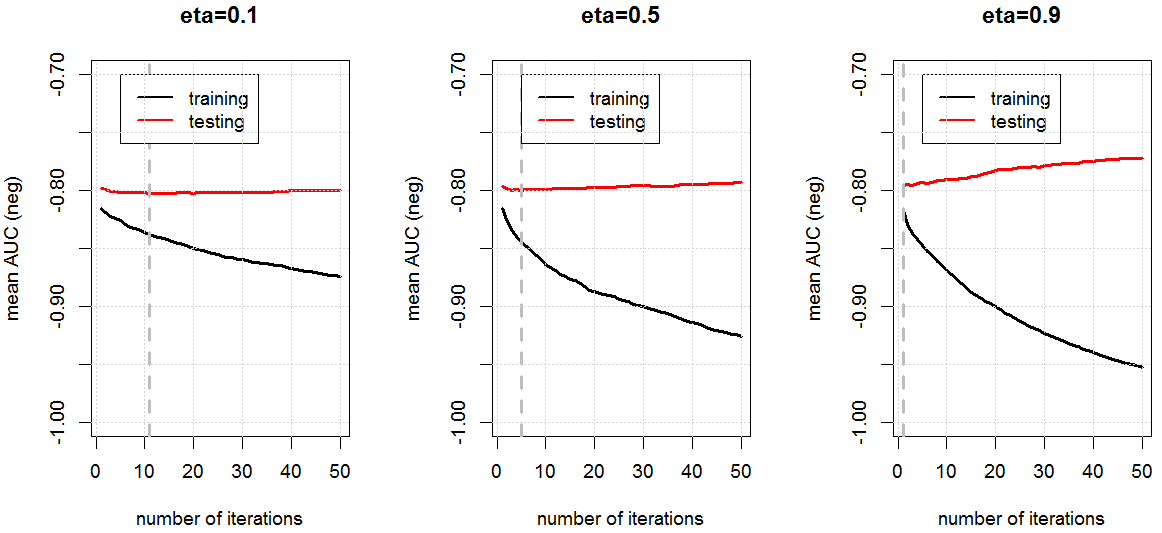

#### Instantiate GridSearchCV class

In [ ]:
# 7  Grid Search (16 * 2) iterations
#    Create Grid Search object first with all necessary
#    specifications. Note that data, X, as yet is not specified

#    Data Leakage and pipelining:
#    Pipeline avoids data leakage during GridSearch
#    See this: https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

clf = GridSearchCV(pipe_xg,            # pipeline object
                   parameters,         # possible parameters
                   n_jobs = 2,         # USe parallel cpu threads
                   cv =2 ,             # No of folds
                   verbose =1,         # Higher the value, more the verbosity
                   scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                   refit = 'roc_auc'   # Refitting final model on what parameters?
                                       # Those which maximise auc
                   )



In [ ]:
## 7.1 Delete objects not needed
#      We need X_train, y_train, X_test, y_test
del X
del data
del y
gc.collect()

0

#### Model fitting

In [ ]:
# 7.2. Start fitting pipeline to data
print("\n\n--Takes time...---\n")
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60               # 25 minutes



--Takes time...---

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[23:52:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('sts', StandardScaler()),
                                       ('pca', PCA()),
                                       ('xg',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importan...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=3,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=2,
             param_grid={'pca__n_components': [25, 30],
                         'xg__booster': ['gbtree', 'gblinear'],
                         'xg__learning_rate': [0.03, 0.05],
                         'xg__max_depth': [4, 6],
                         'xg__n_estimators': [200, 300]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'], verbose=1)

30.01009809176127

#### Performance Scores

In [ ]:
# 7.3
f"Best score: {clf.best_score_} "            # 'Best score: 0.8804992694908675 '

# 7.3.1
print()
f"Best parameter set {clf.best_params_}"

'Best score: 0.883106004901076 '

"Best parameter set {'pca__n_components': 30, 'xg__booster': 'gbtree', 'xg__learning_rate': 0.05, 'xg__max_depth': 6, 'xg__n_estimators': 300}"

In [ ]:
# 7.4. Make predictions using the best returned model
y_pred = clf.predict(X_test)
print("--Few predictions--\n")
y_pred[:4]



--Few predictions--



array([1, 1, 1, 0])

In [ ]:
# 7.5 Accuracy score
print("\n\n--Accuracy Score--\n")
accuracy = accuracy_score(y_test, y_pred)
accuracy * 100.0             # 'Accuracy: 82.11165535218126'



--Accuracy Score--



81.87704119635593

In [ ]:
# 7.6 Confusion matrix
print("\n\n--Confusion Matrix--\n")
confusion_matrix( y_test,y_pred)



--Confusion Matrix--



array([[ 8327,  3605],
       [ 2721, 20253]])

In [ ]:
# 7.7 F1 score
print("\n\n--F1 Score pos-label: 1--\n")
f1_score(y_test,y_pred, pos_label = 1)      # 0.8664199696263183

print("\n\n--F1 Score pos-label: 0--\n")
f1_score(y_test,y_pred, pos_label = 0)      # 0.729313857223354



--F1 Score pos-label: 1--



0.8649214212504269



--F1 Score pos-label: 0--



0.7247171453437772

In [ ]:
# 7.8 ROC curve and get AUC
print("\n\n--ROC curve--\n")
_=plot_roc_curve(clf, X_test, y_test)

#### Feature importance

In [ ]:
# 7.9 Get feature importances from GridSearchCV best fitted 'xg' model
#     See stackoverflow: https://stackoverflow.com/q/48377296

print("\n\n--How many features--\n")
clf.best_estimator_.named_steps["xg"].feature_importances_.shape

# 7.9.1
print("\n\n---Feature importances---\n")
clf.best_estimator_.named_steps["xg"].feature_importances_



--How many features--



(30,)



---Feature importances---



array([0.11189625, 0.02537681, 0.15277667, 0.0562936 , 0.07947852,
       0.02392177, 0.01019151, 0.04343164, 0.00922595, 0.02443189,
       0.00817355, 0.05883855, 0.01326749, 0.02544978, 0.02019309,
       0.02656274, 0.03592752, 0.01379785, 0.05866168, 0.06505468,
       0.02090958, 0.01361406, 0.01219007, 0.01469112, 0.01423773,
       0.013128  , 0.01080974, 0.01044462, 0.01851071, 0.0085128 ],
      dtype=float32)

In [ ]:
# 7.10 Create a dataframe of feature importances
#      with names of columns and sorted by feature-imp

imp_values = clf.best_estimator_.named_steps["xg"].feature_importances_

df_imp = pd.DataFrame(
                      data = imp_values,
                      index = colnames,
                      columns = ["imp"]
                      ).sort_values(by = 'imp')

# 7.10.1
df_imp

,imp
DER_pt_ratio_lep_tau,0.008174
PRI_jet_all_pt,0.008513
DER_pt_tot,0.009226
DER_prodeta_jet_jet,0.010192
PRI_jet_subleading_eta,0.010445
PRI_jet_subleading_pt,0.010810
PRI_jet_num,0.012190
PRI_jet_leading_phi,0.013128
DER_lep_eta_centrality,0.013267
PRI_met_sumet,0.013614


In [ ]:
# 7.11 First five columns with least feature importance are:

list(df_imp.index.values[:5])

['DER_pt_ratio_lep_tau',
 'PRI_jet_all_pt',
 'DER_pt_tot',
 'DER_prodeta_jet_jet',
 'PRI_jet_subleading_eta']

## Random Search code to discover best pipeline parameters

#### Parameter space
Define parameter space

In [ ]:
##################### EE. Randomized Search #################

# Tune parameters using randomized search
# 9.0 Hyperparameters to tune and their ranges
parameters = {'xg__learning_rate':  uniform(0, 1),
              'xg__n_estimators':   range(50,300),
              'xg__max_depth':      range(3,10),
              'pca__n_components' : range(20,30)}

#### Instantiate RandomSearchCV class

In [ ]:
# 9.1 Tune parameters using random search
#     Create the object first

rs = RandomizedSearchCV(
                          pipe_xg,
                          param_distributions=parameters,
                          scoring= ['roc_auc', 'accuracy'],
                          n_iter=4,           # Max combination of
                                              # parameter to try. Default = 10
                          verbose = 1,
                          refit = 'roc_auc',
                          n_jobs = 2,          # Use parallel cpu threads
                          cv = 2               # No of folds.
                                              # So n_iter * cv combinations
                        )


#### Start training RandomSearchCV object

In [ ]:
# 9.2 Run random search for 25 iterations. 21 minutes:

start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60   # 4 minutes

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[00:02:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('sts', StandardScaler()),
                                             ('pca', PCA()),
                                             ('xg',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            im...
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=None, ...))]),
                   n_iter=4, n_jobs=2,
                   param_distributions={'pca__n_components': range(20, 30),
                                        'xg__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e5f96e8d6c0>,
                                        'xg__max_depth': range(3, 10),
                                        'xg__n_estimators': range(50, 300)},
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'], verbose=1)

4.888977726300557

#### Performance scores

In [ ]:
# 9.3 Evaluate
f"Best score: {rs.best_score_} " ;print()           # 'Best score: 0.8780097831252602 '
f"Best parameter set: {rs.best_params_} " ; print()


# 9.4 Make predictions from the best returned model
y_pred = rs.predict(X_test)


# 9.5 Accuracy and f1_score
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"   ; print()      # 'Accuracy: 82.0142648448913'
f"f1 score: {f1_score(y_test,y_pred, pos_label = 1)}" ; print()     # 0.8655661892221722


## Bayesian Optimization
Please see this [quora](https://www.quora.com/How-does-Bayesian-optimization-work) answer.

### Understanding Bayesian optimization process

This is the idea: Sample some input-outputs (less than 10) and use them to guess the true loss function with something called a `'Gaussian Process'` (or ‘GP’ here). Then use that guessed function to determine where to evaluate next. Evaluate that point, add it to our set of input-outputs and infer the guessed function once again. Repeat this until you've exhausted your budget of evaluations (ie no of iterations or some other stopping criteria). If the GP is any good at guessing the true function, we’ll do better than random sampling.

If you don't know what a GP is, I can tell you the important pieces for our purposes. It's way of inferring a function (like the one we see above) from samples of its inputs and outputs. Not only that, it also provides a distribution over the outputs. So when you guess the function output at some given x
, the GP will also tell us the probability of finding it within given ranges.

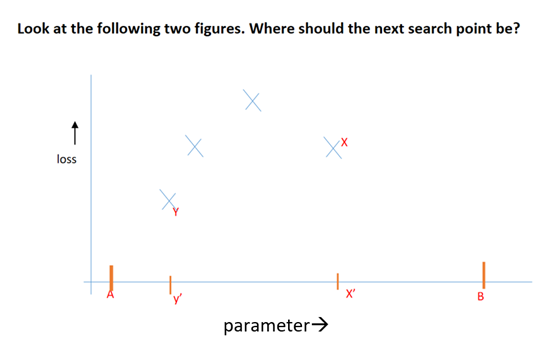

<i>Figure 1</i>: Where should the next search point be? Should it be between points X’and B, or between Y’ and A where there is not much space left. Maybe loss Y cannot come down to that extent. Be <b>explorative</b> than <b>exploitative</b>.

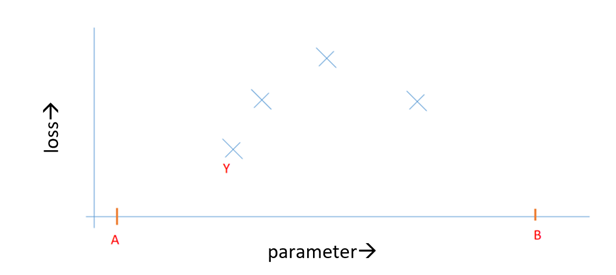

<i>Figure 2</i>: Where should the next parameter search be? Answer: On the left: Between Y and A. There is sufficient gap for Y to be able to still come down. Be <b>exploitative</b> than <b>explorative</b>.

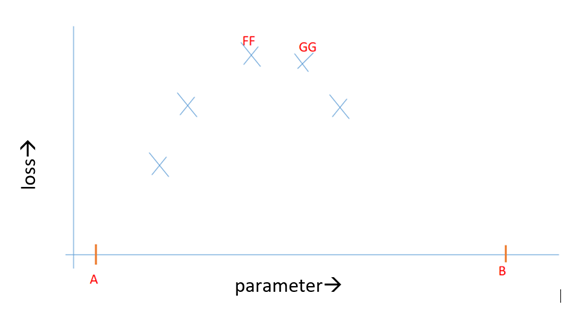

<i>Figure 3</i>: Should there be parameter search between points FF and GG. That depends upon two hyperparameters of Gaussian process: `Smoothness` and `Amplitude`. Or in other words, how smooth and how high/low a curve can permitted to be between two adjacent points. If large `Amplitude` is permitted and less `Smoothness` is tolerated, then search for parameter value will also be conducted between these two points. Below are samples drawn from a GP with various kernel parameters.

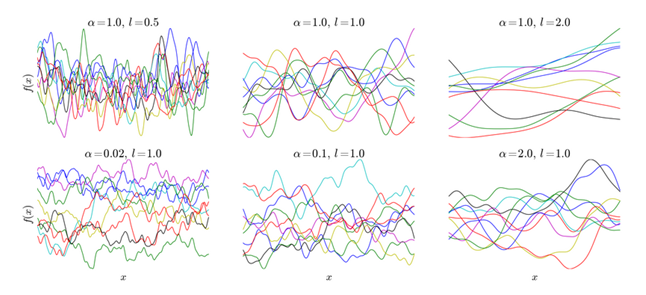

To do the bayesian parameter tuning, we use the BayesSearchCV class of scikit-optimize. It works basically as a drop-in replacement for `GridSearchCV` and `RandomSearchCV` and generally we get better results with it.

In the following coe,  we define the BayesSearchCV object, and write a short convenience function that will be used during optimization to output current status of the tuning. Locally we have access to more cores and run with n_jobs=4 for the classifier, and n_jobs=6 for the BayesSearchCV object.

## Bayesian Search Code
Please see this [link](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

#### Parameter search space
For xgboost parameters, see [here](https://xgboost.readthedocs.io/en/stable/parameter.html)

Uniform distribution in the space between [10, 100] means if two intervals are equal (say, [10,15] and [15,20]) then probability of a point getting selected in between them is equal.<br>
log-uniform distribution is used when the search space is very large, say (10, 100000) or (10, 10^5). log uniform means that if points A, B, C, D are such that log(A) - log(B) = log(C) - log(D) then probability of selection of a point between A and B is same as between C and D. Example: A = 10, B =100, C =1000 and D = 10000.

In [ ]:
# 10.0 Laydown search space of parameters
# https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

params={
         'min_child_weight': Integer(0, 50),  # min no of instances needed to be in each node before split
         'max_depth': Integer(1, 10),         # Maximum depth of a tree.
         'subsample': Real (0.5, 1.0, 'uniform'),  # Subsample ratio of the training instances.
                                                   # Setting it to 0.5 means that XGBoost would
                                                   # randomly sample half of the training data prior
                                                   # to growing trees. and this will prevent overfitting.
         'colsample_bytree': Real(0.5, 1.0, 'uniform'), # subsample ratio of cols when constructing each tree
         'reg_lambda':Real(1e-5,100,prior = 'log-uniform'), # L2 reg term on weights. Increasing this value will make model more conservative
                                                            #  ie move towards simpler model
         'reg_alpha': Real(1e-5,100,prior= 'log-uniform'),  # L1 reg
         'gamma': Real(1e-9, 0.5, 'log-uniform'),   # Min loss reduction required to make a further partition
                                                    # on a leaf node of the tree. The larger gamma is, the
                                                    # more conservative the algorithm will be leading to simpler models.
         'learning-rate': Real(0.01,0.2,prior='log-uniform'), # How much weight should shrink after each step
                                                              # to make boosting process (NOT model) more conservative
         'scale_pos_weight': Real(1e-6, 500, 'log-uniform'),  # Control the balance of pos and neg weights, useful for unbalanced classes
         'n_estimators': Integer(50, 100)   # Max number of trees
        }

#### Instantaite Bayesian Search tuner
And also define a callback function to print tuning status after each iteration


In [ ]:
# Ref: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
"""
class skopt.BayesSearchCV(
                           estimator,
                           search_spaces,
                           n_iter=50,
                           scoring=None,
                           fit_params=None, # params to pass to fit method
                           refit=True,  # Refit the best estimator with the entire dataset.
                           cv=None,
                           verbose=0,
                           return_train_score=False # If 'True', the cv_results_
                                                    #  attribute will include
                                                    #   training scores.
                           )
"""

`BayesSearchCV` implements a `“fit”` and a `“score”` method. It also implements `“predict”` and `“predict_proba”`methods.<br>
The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.<br>
In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.<br>  
The parameters selected are those that maximize the score *of the held-out data*, according to the `scoring` parameter.

In [ ]:
# 10.1 Instantiate our search engine (through cross-validation):
#      For optimizer_kwargs, refer:
#        https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html#skopt.Optimizer

bayes_tuner=BayesSearchCV(
                            XGBClassifier(
                                            n_jobs = 1,
                                            objective = 'binary:logistic',
                                            eval_metric = 'auc',
                                            silent=1,
                                            tree_method='approx'
                                            ),
                            params,
                            n_iter=5,              # No of parameter settings that are tried
                            scoring='roc_auc',     # The criteria for best model. Maximise
                            optimizer_kwargs={     # Dict of arguments passed to Optimizer.
                                               'n_initial_points' : 5,  # Initial random pts before intelligence sets in
                                                                        #  default: 10
                                               'initial_point_generator':'random' # Random serach for init pts
                                              },
                            cv = StratifiedKFold(
                                                  n_splits=3,
                                                  shuffle=True,
                                                  random_state=42
                                                ),
                            refit = True, # Refit the best estimator
                                          #   so as to make predictions
                            verbose = 1,
                            return_train_score= True
                    )


In [ ]:
# 10.2 This function is called after each parameter
#      fitting to print current status:

def status_print(optim_result):
  """Status callback durring bayesian hyperparameter search"""

  # 10.2.1 Get all the models tested so far in DataFrame format
  # cv_results_: A dict with keys as column headers and
  #              values as columns
  #        model_results dataframe is not being printed
  model_results = pd.DataFrame(bayes_tuner.cv_results_)

  # 10.2.2 Get current parameters and the best parameters
  # best_params_: A dict of parameter settings that
  #               give the best results on the hold out data.
  best_params = pd.Series(bayes_tuner.best_params_)

  print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(model_results),
        np.round(bayes_tuner.best_score_, 4),  # Score of best_estimator on the left out data.
        bayes_tuner.best_params_
    ))

#### Begin parameter tuning
And also print results

In [ ]:
# 11.0 Begin parameter tuning

start = time.time()
res=bayes_tuner.fit(
                      X_train,
                      y_train,
                      #callback=status_print
                    )

end = time.time()

f"{(end - start)/60} minutes "    # 3 minutes on Colab

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


'1.2092880566914876 minutes '

In [ ]:
# 11.1 Get results
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
res.best_estimator_


XGBClassifier(colsample_bytree=0.5443841771187318, eval_metric='auc',
              gamma=0.004146852339548524, learning-rate=0.017345391762640553,
              max_depth=10, min_child_weight=21, n_estimators=85,
              reg_alpha=0.15933585160766212, reg_lambda=59.15164584752442,
              scale_pos_weight=0.03836413919693136, silent=1,
              subsample=0.503381762251277, tree_method='approx')

In [ ]:
# 11.2
res.best_score_


0.8859791149660241

In [ ]:
# 11.3
res.best_params_

OrderedDict([('colsample_bytree', 0.5443841771187318),
             ('gamma', 0.004146852339548524),
             ('learning-rate', 0.017345391762640553),
             ('max_depth', 10),
             ('min_child_weight', 21),
             ('n_estimators', 85),
             ('reg_alpha', 0.15933585160766212),
             ('reg_lambda', 59.15164584752442),
             ('scale_pos_weight', 0.03836413919693136),
             ('subsample', 0.503381762251277)])

## Extra
This code is not tested

In [ ]:
############### FF. Fitting parameters in our model ##############
###############    Model Importance   #################

# 9. Model with parameters of grid search
model_gs = XGBClassifier(
                    learning_rate = clf.best_params_['xg__learning_rate'],
                    max_depth = clf.best_params_['xg__max_depth'],
                    n_estimators=clf.best_params_['xg__max_depth']
                    )

# 9.1 Model with parameters of random search
model_rs = XGBClassifier(
                    learning_rate = rs.best_params_['xg__learning_rate'],
                    max_depth = rs.best_params_['xg__max_depth'],
                    n_estimators=rs.best_params_['xg__max_depth']
                    )


# 9.2 Modeling with both parameters
start = time.time()
model_gs.fit(X_train, y_train)
model_rs.fit(X_train, y_train)
end = time.time()
(end - start)/60


# 9.3 Predictions with both models
y_pred_gs = model_gs.predict(X_test)
y_pred_rs = model_rs.predict(X_test)


# 9.4 Accuracy from both models
accuracy_gs = accuracy_score(y_test, y_pred_gs)
accuracy_rs = accuracy_score(y_test, y_pred_rs)
accuracy_gs
accuracy_rs


In [ ]:
#!pip install PyQt5
import PyQt5
%matplotlib qt5
rs.feature_importances_

# 10.1.1 Importance type: 'weight'
plot_importance(
                rs,
                importance_type = 'weight'   # default
                )

In [ ]:
# 10.1 Plt now

%matplotlib qt5
rs.feature_importances_

# 10.1.1 Importance type: 'weight'
plot_importance(
                rs,
                importance_type = 'weight'   # default
                )
# 10.1.2 Importance type: 'gain'
#        # Normally use this
plot_importance(
                model_rs,
                importance_type = 'gain',
                title = "Feature impt by gain"
                )
plt.show()

# 10.1 Print feature importance
#      https://stackoverflow.com/a/52777909
#      https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
"""
importance_type

    ‘weight’ -      the number of times a feature is used to split the data across all trees.
    ‘gain’ -        the average gain across all splits the feature is used in.
    ‘cover’ -       the average coverage across all splits the feature is used in.
    ‘total_gain’ -  the total gain across all splits the feature is used in.
    ‘total_cover’ - the total coverage across all splits the feature is used in.

"""
# 11.0 Get results in a sorted DataFrame
feature_important = model_gs.get_booster().get_score(importance_type='weight')
feature_important
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values,
                    index=keys,
                    columns=["score"]).            \
                        sort_values(               \
                                     by = "score", \
                                    ascending=False)

# 11.1 Compare the results in the following DataFrame
#      with that obtained using PermutationImportance
#      of eli5 below.

data

In [ ]:
# 10.1 Plt now

%matplotlib qt5
model_gs.feature_importances_
model_rs.feature_importances_
# 10.1.1 Importance type: 'weight'
plot_importance(
                model_gs,
                importance_type = 'weight'   # default
                )
# 10.1.2 Importance type: 'gain'
#        # Normally use this
plot_importance(
                model_rs,
                importance_type = 'gain',
                title = "Feature impt by gain"
                )
plt.show()

# 10.1 Print feature importance
#      https://stackoverflow.com/a/52777909
#      https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
"""
importance_type

    ‘weight’ -      the number of times a feature is used to split the data across all trees.
    ‘gain’ -        the average gain across all splits the feature is used in.
    ‘cover’ -       the average coverage across all splits the feature is used in.
    ‘total_gain’ -  the total gain across all splits the feature is used in.
    ‘total_cover’ - the total coverage across all splits the feature is used in.

"""
# 11.0 Get results in a sorted DataFrame
feature_important = model_gs.get_booster().get_score(importance_type='weight')
feature_important
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values,
                    index=keys,
                    columns=["score"]).            \
                        sort_values(               \
                                     by = "score", \
                                    ascending=False)

# 11.1 Compare the results in the following DataFrame
#      with that obtained using PermutationImportance
#      of eli5 below.

data
